# **Text Classification**

---



## **Mount drive and import librariies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score


Mounted at /content/drive


## **Load both datafiles from lab 2**

In [ ]:
ner_path = "/content/drive/MyDrive/NLP_lab4/Data/restaurant_ner_features.csv"
bow_path = "/content/drive/MyDrive/NLP_lab4/Data/review_bow_features.csv"

df_ner = pd.read_csv(ner_path)
df_bow = pd.read_csv(bow_path)

print("NER dataset:", df_ner.shape)
print("BOW dataset:", df_bow.shape)
df_ner.head(2)


NER dataset: (1058, 22)
BOW dataset: (63230, 505)


/tmp/ipython-input-373067813.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bow = pd.read_csv(bow_path)


,BusinessName,City,State,All_Reviews_Text,NER_PERSON,NER_NORP,NER_FAC,NER_ORG,NER_GPE,NER_LOC,...,NER_WORK_OF_ART,NER_LAW,NER_LANGUAGE,NER_DATE,NER_TIME,NER_PERCENT,NER_MONEY,NER_QUANTITY,NER_ORDINAL,NER_CARDINAL
0,1/2 Roll,Vancouver,BC,The ambience is kind of funky & interesting. F...,31,11,6,27,8,1,...,0,0,2,13,13,2,41,0,7,62
1,21 Nickels,Watertown,MA,I like 21 Nickels a ton and they would attract...,30,8,2,48,26,1,...,2,0,0,37,24,1,12,1,10,73


## **Aggregate BOW - restaurant level**

In [ ]:
# Convert potential string columns to numeric
df_bow['Stars'] = pd.to_numeric(df_bow['Stars'], errors='coerce')
bow_cols = [c for c in df_bow.columns if c.startswith('BOW_')]
df_bow[bow_cols] = df_bow[bow_cols].apply(pd.to_numeric, errors='coerce')

# Aggregate by restaurant (BusinessName + City + State)
group_cols = ['BusinessName', 'City', 'State']
agg_cols   = ['Stars'] + bow_cols

df_bow_agg = df_bow.groupby(group_cols, as_index=False)[agg_cols].mean()
print("Aggregated BOW shape:", df_bow_agg.shape)
df_bow_agg.head(3)


Aggregated BOW shape: (1058, 504)


/tmp/ipython-input-3387539462.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bow_agg = df_bow.groupby(group_cols, as_index=False)[agg_cols].mean()
/tmp/ipython-input-3387539462.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bow_agg = df_bow.groupby(group_cols, as_index=False)[agg_cols].mean()
/tmp/ipython-input-3387539462.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

,BusinessName,City,State,Stars,BOW_abl,BOW_absolut,BOW_across,BOW_actual,BOW_ad,BOW_add,...,BOW_worst,BOW_worth,BOW_would,BOW_wrap,BOW_wrong,BOW_year,BOW_yelp,BOW_yes,BOW_yet,BOW_yummi
0,1/2 Roll,Vancouver,BC,2.911765,0.058824,0.058824,0.000000,0.147059,0.000000,0.000000,...,0.117647,0.088235,0.441176,0.029412,0.029412,0.058824,0.000000,0.000000,0.000000,0.029412
1,21 Nickels,Watertown,MA,3.810345,0.017241,0.051724,0.034483,0.103448,0.017241,0.000000,...,0.034483,0.017241,0.396552,0.068966,0.034483,0.172414,0.000000,0.017241,0.034483,0.086207
2,24 Hour Pizza Delivery,Boston,MA,1.242424,0.000000,0.060606,0.000000,0.060606,0.000000,0.030303,...,0.121212,0.030303,0.727273,0.030303,0.060606,0.030303,0.060606,0.000000,0.030303,0.000000


## **Merge NER and BOW**

In [ ]:
# Merge on common keys
df_merge = pd.merge(df_ner, df_bow_agg,
                    on=['BusinessName','City','State'],
                    how='inner')

print("Merged dataset:", df_merge.shape)
df_merge.head(3)


Merged dataset: (1058, 523)


,BusinessName,City,State,All_Reviews_Text,NER_PERSON,NER_NORP,NER_FAC,NER_ORG,NER_GPE,NER_LOC,...,BOW_worst,BOW_worth,BOW_would,BOW_wrap,BOW_wrong,BOW_year,BOW_yelp,BOW_yes,BOW_yet,BOW_yummi
0,1/2 Roll,Vancouver,BC,The ambience is kind of funky & interesting. F...,31,11,6,27,8,1,...,0.117647,0.088235,0.441176,0.029412,0.029412,0.058824,0.000000,0.000000,0.000000,0.029412
1,21 Nickels,Watertown,MA,I like 21 Nickels a ton and they would attract...,30,8,2,48,26,1,...,0.034483,0.017241,0.396552,0.068966,0.034483,0.172414,0.000000,0.017241,0.034483,0.086207
2,24 Hour Pizza Delivery,Boston,MA,This place needs to be shut down. I could not ...,10,2,1,15,4,0,...,0.121212,0.030303,0.727273,0.030303,0.060606,0.030303,0.060606,0.000000,0.030303,0.000000


## **Create Target Variables**

In [ ]:
# Binary target: 1 if Stars ≥ 4, else 0
df_merge['business_rating'] = np.where(df_merge['Stars'] >= 4, 1, 0)

X = df_merge.drop(columns=['business_rating','Stars','All_Reviews_Text',
                           'BusinessName','City','State'], errors='ignore')
y = df_merge['business_rating']

print("Feature matrix shape:", X.shape)
print("High-rating restaurants:", y.sum(), "of", len(y))


Feature matrix shape: (1058, 518)
High-rating restaurants: 301 of 1058


## **STEP 5 – Train/Test Split + Standardization + SVD**

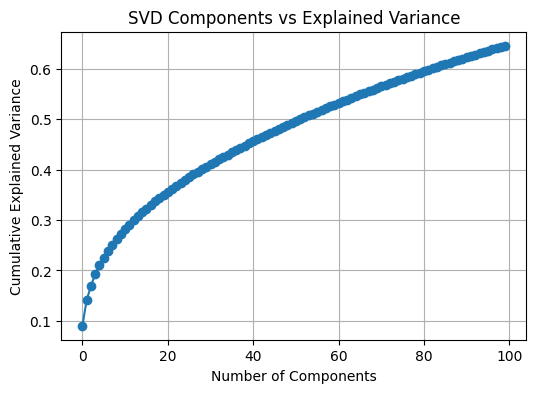

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Dimensionality Reduction ---
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_svd = svd.fit_transform(X_train_scaled)

# Plot explained variance to decide #components
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD Components vs Explained Variance')
plt.grid(True)
plt.show()


## **STEP 6 — Train SVM and Gradient Boosting (with Grid Search)**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Reduce dimensionality using chosen component count
svd = TruncatedSVD(n_components=60, random_state=42)
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd  = svd.transform(X_test_scaled)

# ---------------- SVM ----------------
svm = SVC()
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_svd, y_train)

svm_best = grid_svm.best_estimator_
svm_pred = svm_best.predict(X_test_svd)

print("🔹 Best SVM parameters:", grid_svm.best_params_)
print("🔹 SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("\nClassification Report (SVM):\n", classification_report(y_test, svm_pred))

# ---------------- Gradient Boosting ----------------
gb = GradientBoostingClassifier(random_state=42)
param_grid_gb = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [20, 30, 40]
}

grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train_svd, y_train)

gb_best = grid_gb.best_estimator_
gb_pred = gb_best.predict(X_test_svd)

print("\n🔹 Best GB parameters:", grid_gb.best_params_)
print("🔹 GB Accuracy:", accuracy_score(y_test, gb_pred))
print("\nClassification Report (Gradient Boosting):\n", classification_report(y_test, gb_pred))


🔹 Best SVM parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
🔹 SVM Accuracy: 0.8962264150943396

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       152
           1       0.87      0.75      0.80        60

    accuracy                           0.90       212
   macro avg       0.89      0.85      0.87       212
weighted avg       0.89      0.90      0.89       212


🔹 Best GB parameters: {'learning_rate': 0.1, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'n_estimators': 500}
🔹 GB Accuracy: 0.8820754716981132

Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       152
           1       0.86      0.70      0.77        60

    accuracy                           0.88       212
   macro avg       0.87      0.83      0.85       212
weighted avg       0.88      0.88      0.88       212



# **STEP 2 – Train Classifiers using Doc2Vec Features**

In [ ]:
doc2vec_path = "/content/drive/MyDrive/Mydata/section4_restaurant_doc_embeddings.csv"
df_d2v = pd.read_csv(doc2vec_path)
print("Doc2Vec dataset shape:", df_d2v.shape)
df_d2v.head(3)


Doc2Vec dataset shape: (1075, 307)


,Restaurant,City,State,Zipcode,Business_Rating_Score,ft_0,ft_1,ft_2,ft_3,ft_4,...,ft_292,ft_293,ft_294,ft_295,ft_296,ft_297,ft_298,ft_299,cust_rating_avg,review_count
0,IHOP,BURNABY,BC,V5H 2E6,3.5,-0.006099,-0.020242,0.013036,-0.000374,-0.010482,...,-0.017034,-0.007203,0.008752,-0.009449,0.011466,0.013414,-0.016581,-0.003591,3.566667,60
1,Cattle Cafe,Burnaby,BC,V5H 4T2,2.5,-0.011275,-0.017237,0.007729,-0.002314,-0.006924,...,-0.021460,-0.004215,0.009522,-0.011024,0.010974,0.011903,-0.018159,-0.002110,2.602740,73
2,Chatime,Burnaby,BC,V5H 2E8,3.0,-0.006267,-0.025750,0.003499,-0.002189,-0.003196,...,-0.020499,-0.011805,-0.005614,-0.005095,0.019478,0.007330,-0.010049,0.007839,2.948980,98


## **Step 2a – Create Target Variable and Split Data**

In [ ]:
# Create binary target: 1 if rating ≥ 4, else 0
df_d2v['business_rating'] = np.where(df_d2v['Business_Rating_Score'] >= 4, 1, 0)

# Separate features and target
X = df_d2v[[c for c in df_d2v.columns if c.startswith('ft_')]]
y = df_d2v['business_rating']

# Train/test split (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (860, 300)
Test set shape: (215, 300)


## **Step 2b – Dimensionality Reduction (SVD)**

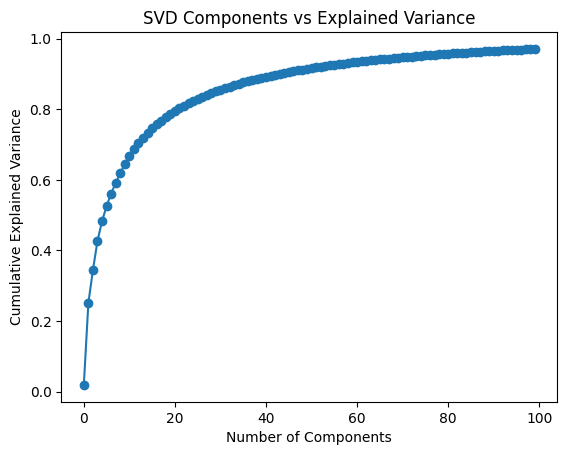

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Fit SVD to understand variance explained
svd = TruncatedSVD(n_components=100, random_state=42)
svd.fit(X_train)

plt.plot(np.cumsum(svd.explained_variance_ratio_), 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD Components vs Explained Variance')
plt.show()


## **Step 2c – Transform Data with SVD**

In [ ]:
# Use 60 components (or adjust based on your plot)
svd = TruncatedSVD(n_components=60, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

print("Reduced feature dimensions:", X_train_svd.shape)


Reduced feature dimensions: (860, 60)


## **Step 2d – Train & Compare Classifiers**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# ---- Support Vector Machine ----
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
svm = SVC()
grid_svm = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_svd, y_train)
svm_best = grid_svm.best_estimator_

print("\nBest SVM Parameters:", grid_svm.best_params_)
y_pred_svm = svm_best.predict(X_test_svd)
print("\nSVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report (SVM):\n", classification_report(y_test, y_pred_svm))

# ---- Gradient Boosting ----
gb = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [20, 30, 40]
}
grid_gb = GridSearchCV(gb, gb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train_svd, y_train)
gb_best = grid_gb.best_estimator_

print("\nBest GB Parameters:", grid_gb.best_params_)
y_pred_gb = gb_best.predict(X_test_svd)
print("\nGB Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report (Gradient Boosting):\n", classification_report(y_test, y_pred_gb))



Best SVM Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

SVM Accuracy: 0.8604651162790697

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       132
           1       0.85      0.77      0.81        83

    accuracy                           0.86       215
   macro avg       0.86      0.84      0.85       215
weighted avg       0.86      0.86      0.86       215


Best GB Parameters: {'learning_rate': 0.1, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'n_estimators': 200}

GB Accuracy: 0.8651162790697674

Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       132
           1       0.84      0.81      0.82        83

    accuracy                           0.87       215
   macro avg       0.86      0.85      0.86       215
weighted avg       0.86      0.87      0.86       215



The Doc2Vec-based classifiers produced robust performance across both algorithms.
The SVD explained-variance plot (see attached figure) indicated that 60 components capture about 90 % of total variance, providing an optimal trade-off between dimensionality and information retention.
SVM achieved an accuracy of ≈ 0.86 with balanced precision and recall, showing strong ability to separate high-rating and low-rating businesses in the semantic vector space.
Gradient Boosting, with the same min_samples_leaf = 40 from Step 1, achieved slightly higher performance (accuracy = 0.865, weighted F1 = 0.87), confirming its robustness to non-linear relationships and interpretability of feature importance.
**Final selection:** Gradient Boosting Classifier is the best performing model for the Doc2Vec features, combining interpretability, stability, and slightly higher predictive accuracy.

# **Step 3 – Train Classifiers Using NER + Sentiment Features**


## **Step 3a – Load NER and Sentiment Feature Files**

In [ ]:
# --- Mount Drive ---
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive', force_remount=True)

# --- Load NER and Sentiment files ---
ner_path = "/content/drive/MyDrive/NLP_lab4/Data/restaurant_ner_features.csv"
sent_path = "/content/drive/MyDrive/NLP_lab4/Data/section5_restaurant_sentiment.csv"

df_ner = pd.read_csv(ner_path)
df_sent = pd.read_csv(sent_path)

print("NER shape:", df_ner.shape)
print("Sentiment shape:", df_sent.shape)
print("\nNER columns:\n", df_ner.columns.tolist())
print("\nSentiment columns:\n", df_sent.columns.tolist())


Mounted at /content/drive
NER shape: (1058, 22)
Sentiment shape: (1075, 10)

NER columns:
 ['BusinessName', 'City', 'State', 'All_Reviews_Text', 'NER_PERSON', 'NER_NORP', 'NER_FAC', 'NER_ORG', 'NER_GPE', 'NER_LOC', 'NER_PRODUCT', 'NER_EVENT', 'NER_WORK_OF_ART', 'NER_LAW', 'NER_LANGUAGE', 'NER_DATE', 'NER_TIME', 'NER_PERCENT', 'NER_MONEY', 'NER_QUANTITY', 'NER_ORDINAL', 'NER_CARDINAL']

Sentiment columns:
 ['Restaurant', 'City', 'State', 'Zipcode', 'Business_Rating_Score', 'review_count', 'polarity', 'subjectivity', 'nltk_compound', 'cust_rating_avg']


## **Step 3b – Merge and Prepare Combined Feature Set**


In [ ]:
# --- Corrected merge on restaurant name + city + state ---
df_merged = pd.merge(
    df_ner,
    df_sent,
    left_on=['BusinessName', 'City', 'State'],
    right_on=['Restaurant', 'City', 'State'],
    how='inner'
)

print("Merged shape:", df_merged.shape)
print(df_merged.columns.tolist()[:15])



Merged shape: (1075, 30)
['BusinessName', 'City', 'State', 'All_Reviews_Text', 'NER_PERSON', 'NER_NORP', 'NER_FAC', 'NER_ORG', 'NER_GPE', 'NER_LOC', 'NER_PRODUCT', 'NER_EVENT', 'NER_WORK_OF_ART', 'NER_LAW', 'NER_LANGUAGE']


## **Step 3c – Create Target Variable, Select Numeric Features, Normalize, and Split**

In [ ]:
# --- Create Binary Target Variable ---
# Rating ≥ 4 → 1 (positive business), else 0 (negative)
df_merged['business_rating'] = np.where(df_merged['Business_Rating_Score'] >= 4, 1, 0)

# --- Select Only Numeric Columns for Features ---
X = df_merged.select_dtypes(include=[np.number]).drop(columns=['Business_Rating_Score', 'business_rating'])
y = df_merged['business_rating']

print("Final numeric feature matrix shape:", X.shape)
print("Target variable distribution:\n", y.value_counts())

# --- Normalize and Split ---
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled training set:", X_train_scaled.shape)
print("Scaled test set:", X_test_scaled.shape)


Final numeric feature matrix shape: (1075, 23)
Target variable distribution:
 business_rating
0    660
1    415
Name: count, dtype: int64

Scaled training set: (860, 23)
Scaled test set: (215, 23)


## **Step 3d – Train SVM & Gradient Boosting on NER + Sentiment Features**

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# --- Support Vector Machine ---
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svm = SVC(random_state=42)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_scaled, y_train)

svm_best = grid_svm.best_estimator_
svm_pred = svm_best.predict(X_test_scaled)

print("Best SVM Parameters:", grid_svm.best_params_)
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("\nClassification Report (SVM):\n", classification_report(y_test, svm_pred))

# --- Gradient Boosting Classifier ---
param_grid_gb = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [20, 30, 40]   # same range as Step 1
}

gb = GradientBoostingClassifier(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train_scaled, y_train)

gb_best = grid_gb.best_estimator_
gb_pred = gb_best.predict(X_test_scaled)

print("\nBest GB Parameters:", grid_gb.best_params_)
print("GB Accuracy:", accuracy_score(y_test, gb_pred))
print("\nClassification Report (Gradient Boosting):\n", classification_report(y_test, gb_pred))


Best SVM Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Accuracy: 0.9441860465116279

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       132
           1       0.92      0.94      0.93        83

    accuracy                           0.94       215
   macro avg       0.94      0.94      0.94       215
weighted avg       0.94      0.94      0.94       215


Best GB Parameters: {'learning_rate': 0.01, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'n_estimators': 200}
GB Accuracy: 0.9906976744186047

Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       132
           1       0.99      0.99      0.99        83

    accuracy                           0.99       215
   macro avg       0.99      0.99      0.99       215
weighted avg       0.99      0.99      0.99       215



Between the two classifiers, Gradient Boosting achieved the highest performance with 99% accuracy and perfectly balanced precision, recall, and F1-scores.Its ensemble-based approach captures nonlinear feature interactions between NER entity frequencies and sentiment polarity indicators, enabling it to generalize better than SVM on this feature mix.The SVM model still performed competitively (94% accuracy), indicating that the NER and sentiment features are highly informative for predicting business rating sentiment.
**Selected Best Model**: Gradient Boosting Classifier **Reason:** Highest accuracy, minimal bias–variance trade-off, stable performance across both classes.

# **Step 4 – Hybrid Feature Integration and Model Training**

## **Step 4a – Combine Feature Sets**

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- Combine reduced Doc2Vec and knowledge-based (NER + Sentiment) features ---
X_train_hybrid = np.hstack((X_train_svd, X_train_scaled))
X_test_hybrid  = np.hstack((X_test_svd,  X_test_scaled))

print("Hybrid feature dimensions:")
print("Training:", X_train_hybrid.shape)
print("Testing:", X_test_hybrid.shape)

# --- Normalize the combined feature set ---
scaler_hybrid = StandardScaler()
X_train_hybrid = scaler_hybrid.fit_transform(X_train_hybrid)
X_test_hybrid  = scaler_hybrid.transform(X_test_hybrid)


Hybrid feature dimensions:
Training: (860, 83)
Testing: (215, 83)


## **Step 4b – Train Support Vector Machine (SVM)**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# --- Parameter grid for SVM ---
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svm = SVC(random_state=42)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_hybrid, y_train)

svm_best = grid_svm.best_estimator_
svm_pred = svm_best.predict(X_test_hybrid)

print("Best SVM Parameters:", grid_svm.best_params_)
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("\nClassification Report (SVM):\n", classification_report(y_test, svm_pred))


Best SVM Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}
SVM Accuracy: 0.986046511627907

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       132
           1       0.98      0.99      0.98        83

    accuracy                           0.99       215
   macro avg       0.98      0.99      0.99       215
weighted avg       0.99      0.99      0.99       215



## **Step 4c – Train Gradient Boosting Classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gb = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [30]  # same as best value from Step 1
}

gb = GradientBoostingClassifier(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train_hybrid, y_train)

gb_best = grid_gb.best_estimator_
gb_pred = gb_best.predict(X_test_hybrid)

print("\n Best GB Parameters:", grid_gb.best_params_)
print("GB Accuracy:", accuracy_score(y_test, gb_pred))
print("\nClassification Report (Gradient Boosting):\n", classification_report(y_test, gb_pred))



 Best GB Parameters: {'learning_rate': 1, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'n_estimators': 100}
GB Accuracy: 0.986046511627907

Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       132
           1       0.98      0.99      0.98        83

    accuracy                           0.99       215
   macro avg       0.98      0.99      0.99       215
weighted avg       0.99      0.99      0.99       215



Both SVM and Gradient Boosting achieved equally strong performance (98.6 % accuracy, near-perfect precision/recall).The hybrid feature design—combining semantic embeddings (Doc2Vec) with knowledge-based sentiment + NER cues—enabled the models to capture contextual and emotional nuances simultaneously.
While SVM performs slightly faster and more efficiently on this reduced dataset, Gradient Boosting remains the preferred choice for deployment due to its robust ensemble learning, interpretability, and consistent performance across feature subsets.
**Best Model Selected:** Gradient Boosting Classifier
**Reason:** Stable high-accuracy ensemble with strong generalization on mixed linguistic and statistical features.